In [1]:
import pandas as pd

##################### rename diseases based on icd9 codes
df_icd = pd.read_csv('icd9_to_english.txt',sep=',',index_col=False,dtype={'Disease': str, 'Code': str})
dis = df_icd['Disease']
code = df_icd['Code']
icd_to_dis = {}
for i,d in zip(code,dis):
    icd_to_dis[i] = d
#####################  

from glob import glob
import numpy as np
from collections import defaultdict

resdir = '../results'

frames = []

for f in glob(resdir+'/icd*/*.csv'):
#     print(f)
    df = pd.read_csv(f,sep='\t')
#     print(df.columns)
    if (len(df) > 0):
        df['disease'] = icd_to_dis[f.split('icd9_')[1].split('_')[0].replace('/','')]
        cutoff = f.split('cutoff')[-1].split('_')[0]
        df['rare'] = False if 'noRare' in f else True
#         print(cutoff)
        df['cutoff'] = defaultdict(lambda: '1 visit',{'182':'6 months','365':'1 year'})[cutoff]
#         print(f,'','','','','','',df['algorithm'].iloc[0])
#         not in ['FeatLR0', 'LR', 'RF', 'FeatLR']:
#             print(f)
    #     print(df['dataset'])
        frames.append(df)
    
dfa = pd.concat(frames)
dfa = dfa.dropna(axis=0,how='any')
print('columns:',dfa.columns)
print('datasets:',dfa['dataset'].unique())
print('diseases:',dfa['disease'].unique())
dfa['algorithm'] = dfa['algorithm'].apply(lambda x: 'LR' if x == 'ScaleLR' else x)
print('algorithms:',dfa['algorithm'].unique())
print('seeds:',dfa['seed'].unique())
# print(dfa.loc[dfa['algorithm'].isna()])
dfa.head()


columns: Index(['dataset', 'algorithm', 'parameters', 'seed', 'accuracy', 'f1_macro',
       'bal_accuracy', 'roc_auc', 'time', 'disease', 'rare', 'cutoff'],
      dtype='object')
datasets: ['geis_250.00' 'geis_250.00_cutoff182' 'geis_250.00_cutoff365'
 'geis_250.40' 'geis_250.40_cutoff182' 'geis_250.40_cutoff365'
 'geis_327.23' 'geis_327.23_cutoff182' 'geis_327.23_cutoff365'
 'geis_331.0' 'geis_331.0_cutoff182' 'geis_331.0_cutoff365' 'geis_530.81'
 'geis_530.81_cutoff182' 'geis_530.81_cutoff365' 'geis_571.8'
 'geis_571.8_cutoff182' 'geis_571.8_cutoff365' 'geis_585.9'
 'geis_585.9_cutoff182' 'geis_585.9_cutoff365']
diseases: ['Diabetes' 'Diabetes with renal manifestations' 'Sleep apnea'
 "Alzheimer's disease" 'Esophageal reflux' 'Liver disease'
 'Kidney disease']
algorithms: ['RF' 'LR' 'XGB']
seeds: [27164  9168 11085  3674  1188  4180  7016 16612 30993 14899]


,dataset,algorithm,parameters,seed,accuracy,f1_macro,bal_accuracy,roc_auc,time,disease,rare,cutoff
0,geis_250.00,RF,"bootstrap=True,class_weight=balanced,criterion...",27164,0.851710,0.851672,0.851709,0.924868,11859.727018,Diabetes,True,1 visit
1,geis_250.00,RF,"bootstrap=True,class_weight=balanced,criterion...",9168,0.855070,0.855014,0.854969,0.927769,12042.685165,Diabetes,True,1 visit
2,geis_250.00,RF,"bootstrap=True,class_weight=balanced,criterion...",11085,0.855924,0.855885,0.855898,0.928139,12209.464033,Diabetes,True,1 visit
3,geis_250.00,RF,"bootstrap=True,class_weight=balanced,criterion...",3674,0.851656,0.851633,0.851681,0.926606,12156.885094,Diabetes,True,1 visit
4,geis_250.00,RF,"bootstrap=True,class_weight=balanced,criterion...",1188,0.852990,0.852942,0.853044,0.926543,12240.883428,Diabetes,True,1 visit


In [2]:
df_ranks = pd.DataFrame(dtype=float)
# df_ranks['algorithm'] = dfa.groupby(['dataset','cutoff'])['algorithm']
dfa['rank_auc'] = dfa.groupby(['dataset','cutoff','seed'])['roc_auc'].rank(ascending=False)
df_ranks = dfa[['dataset','cutoff','algorithm','seed','rank_auc']].drop_duplicates()
df_ranks.head()
df_ranks.to_csv('auc_rankings.csv',index=False)

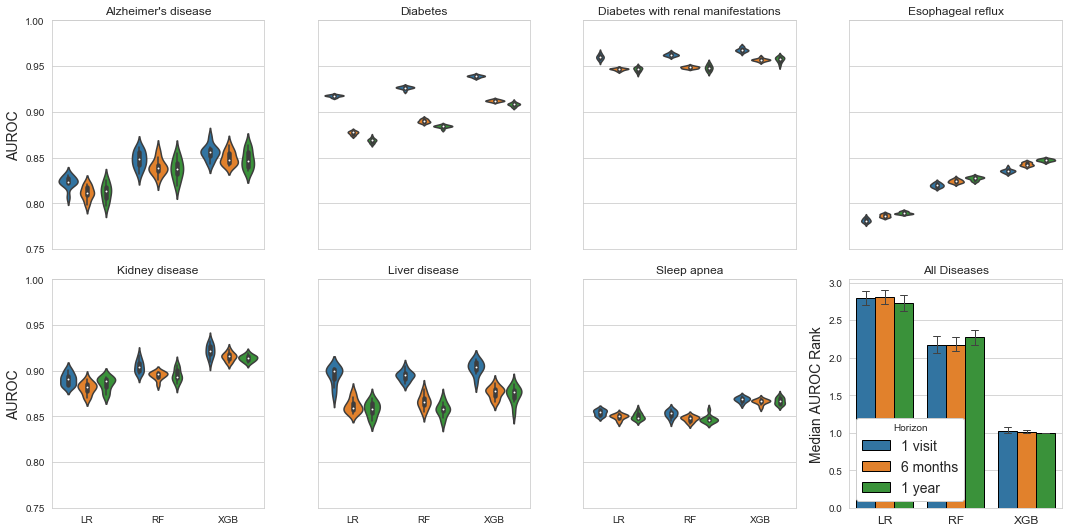

In [3]:
# AUC violin plots
# plot boxplots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

Order=['LR','RF','XGB']
h = plt.figure(figsize=(15,7.5))
# dfs = dfa.loc[dfa.cutoff=='365'] 
dfs = dfa.loc[dfa.rare==True]
n_disease = len(dfs.disease.unique())
# for j, (cutoff, dfc) in enumerate(dfs.groupby('cutoff')):
for i, (disease, dfad) in enumerate(dfs.groupby('disease')):
    ax = h.add_subplot(2,4,i+1)
    leg = i == n_disease - 1
    ax = sns.violinplot(ax = ax, x="algorithm", y="roc_auc", data=dfad, 
                        order=Order, #,'FeatLR_longitudinal'], 
                        hue='cutoff')
    ax.legend_.remove() 
    ax.set_title(disease)
    ax.set_xlabel('')
    if (i) < 4:
        plt.setp( ax.get_xticklabels(), visible=False) 
    if (i) % 4 != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([]) 
    else:
        ax.set_ylabel('AUROC',size=14)
    ax.set_ylim(0.75,1.0)

ax = h.add_subplot(2,4,8)
sns.barplot(ax=ax,data=df_ranks,y='rank_auc',x='algorithm',edgecolor=(0,0,0),capsize=0.1,errwidth=1,
            fill=True,
            hue='cutoff',
            order=Order)
plt.legend(loc='lower left',title='Horizon',fontsize=14,framealpha=1)
#             order=['RF','KernelRidge','','CN','Corr','SXO','CNSXO','CorrSXO'])
# # plt.ylim([-1,1])
plt.xticks(size=12)
plt.title('All Diseases')
plt.ylabel('Median AUROC Rank',size=14)
plt.xlabel('')
plt.tight_layout()
# h.tight_layout()
plt.show() 
# h.savefig('../paper/figs/'+resdir.split('/')[-1] + '/roc_auc_by_year_ranking.pdf',bbox_inches='tight')

In [4]:
for disease,dfg in dfs.groupby('disease'):
    print(disease,dfg.loc[dfg.cutoff=='1 year'].groupby('algorithm')['roc_auc'].median())

Alzheimer's disease algorithm
LR     0.813527
RF     0.837598
XGB    0.845855
Name: roc_auc, dtype: float64
Diabetes algorithm
LR     0.868763
RF     0.884364
XGB    0.908355
Name: roc_auc, dtype: float64
Diabetes with renal manifestations algorithm
LR     0.947293
RF     0.948200
XGB    0.958312
Name: roc_auc, dtype: float64
Esophageal reflux algorithm
LR     0.788947
RF     0.827983
XGB    0.847063
Name: roc_auc, dtype: float64
Kidney disease algorithm
LR     0.889198
RF     0.893287
XGB    0.913925
Name: roc_auc, dtype: float64
Liver disease algorithm
LR     0.858015
RF     0.857535
XGB    0.876419
Name: roc_auc, dtype: float64
Sleep apnea algorithm
LR     0.848485
RF     0.845963
XGB    0.866720
Name: roc_auc, dtype: float64
